In [41]:
import numpy as np
import random
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary 
from torchmetrics import Accuracy, F1Score
import os

# Uploading Spatial Dataset

In [4]:
# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
"""torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False"""

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(15),          
    transforms.ToTensor()                   
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor()                  
])

# Load the full MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_val_transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Apply the validation transform to the validation dataset
val_dataset.dataset.transform = test_val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the sizes
print(f"Image size: {next(iter(train_dataset.dataset))[0].shape}")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 763569.41it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 194231.37it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 957065.79it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1518696.49it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Image size: torch.Size([1, 224, 224])
Train size: 48000
Validation size: 12000
Test size: 10000


In [8]:
mini_batch_image, labels = next(iter(train_loader))
print(f"mini-batch shape: {mini_batch_image.shape}") 

mini-batch shape: torch.Size([64, 1, 224, 224])


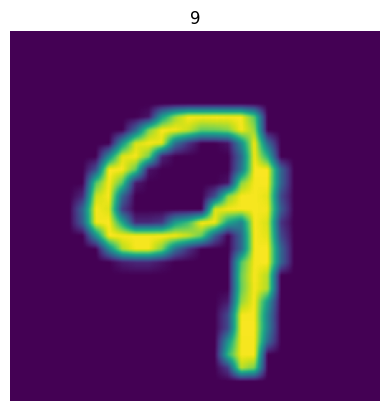

In [11]:
idx = np.random.randint(0,15) 
sample_image = mini_batch_image[idx].permute(1,2,0)
plt.imshow(sample_image)
plt.title(labels[idx].item()) 
plt.axis("off");

# Basic CNN architecture

In [21]:
class BasicNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), 
            nn.Flatten()
        ) 
        self.classifier = nn.Linear(64*56*56, num_classes) # 224 -> 112 -> 56 (final spatial size)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [37]:
num_classes = len(train_dataset.dataset.classes)
spatial_model = BasicNet(num_classes)

In [38]:
device = torch.device("cuda")
spatial_model.to(device)
summary(spatial_model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
               ELU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
               ELU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
           Flatten-7               [-1, 200704]               0
            Linear-8                   [-1, 10]       2,007,050
Total params: 2,025,866
Trainable params: 2,025,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 42.88
Params size (MB): 7.73
Estimated Total Size (MB): 50.79
----------------------------------------------------------------


# Train and Validate 

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spatial_model.parameters(), lr = 0.001) 

In [42]:
save_dir = 'basic_cnn_spatial'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

EPOCHS = 15 
BATCH_SIZE = 64
train_cost, val_cost = [],[]
train_acc, val_acc = [],[]

for epoch in range(EPOCHS):
    train_loss = 0 
    acc_train = Accuracy('multiclass', num_classes=num_classes).to(device)
    spatial_model.train().cuda()  # set the model for training 

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        pred = spatial_model(images)
        curr_loss = criterion(pred, labels)
        train_loss += curr_loss.item()

        curr_loss.backward()
        optimizer.step()

        acc_train(pred, labels)
        
    train_cost.append(train_loss / len(train_loader))
    train_acc.append(acc_train.compute()) 


    val_loss = 0 
    acc_val = Accuracy(task="multiclass", num_classes=10).to(device)
    spatial_model.eval().cuda()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            pred = spatial_model(images)

            curr_loss = criterion(pred, labels)
            val_loss += curr_loss.item()

            _, predicted = torch.max(pred, 1)
            acc_val(predicted, labels)

    val_cost.append( val_loss / len(val_loader))
    val_acc.append(acc_val.compute())

    print(f"[{epoch+1}\{EPOCHS}], train-loss: {train_loss}, train-acc: {acc_train.compute()}, val-loss: {val_loss}, val-acc: {acc_val.compute()}")
    torch.save(spatial_model.state_dict(), f'basic_cnn_spatial/checkpoint_{epoch + 1}') 

torch.save(spatial_model.state_dict(), 'basic_cnn_spatial/spatial_model') 

[1\15], train-loss: 195.33631113171577, train-acc: 0.9250208139419556, val-loss: 44.61935043334961, val-acc: 0.9331666827201843
[2\15], train-loss: 124.50652643293142, train-acc: 0.9519791603088379, val-loss: 35.39350032247603, val-acc: 0.9461666941642761
[3\15], train-loss: 94.13804321642965, train-acc: 0.9627708196640015, val-loss: 34.09680060017854, val-acc: 0.9509999752044678
[4\15], train-loss: 76.40514042880386, train-acc: 0.9687708616256714, val-loss: 29.511383428238332, val-acc: 0.9556666612625122
[5\15], train-loss: 67.07814815617166, train-acc: 0.972083330154419, val-loss: 29.101515899877995, val-acc: 0.9592499732971191
[6\15], train-loss: 53.60198889835738, train-acc: 0.9773749709129333, val-loss: 32.08173567056656, val-acc: 0.9551666378974915
[7\15], train-loss: 51.957172836060636, train-acc: 0.9772291779518127, val-loss: 33.97549305297434, val-acc: 0.953166663646698
[8\15], train-loss: 51.996532629360445, train-acc: 0.9778125286102295, val-loss: 34.538281335961074, val-acc

# Testing

In [44]:
Final_spaital_model = BasicNet(num_classes)
Final_spaital_model.load_state_dict(torch.load("spatial_basic_cnn"))

<All keys matched successfully>

In [47]:
acc = Accuracy(task="multiclass", num_classes=10).to(device)
f1 = F1Score('multiclass', num_classes=num_classes).to(device)

Final_spaital_model.eval().cuda()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        predictions = Final_spaital_model(images) # neglict the auxiliary classifiers 

        _, predicted = torch.max(predictions, 1)

        acc(predicted, labels)
        f1(predicted, labels)


print(f"Test Accuracy: {acc.compute().data:.3f}")
print(f"F1 : {f1.compute().data:.3f}")

Test Accuracy: 0.959
F1 : 0.959
